In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from scipy import stats
import warnings
from itertools import product


plt.rcParams['figure.figsize'] = (20, 14)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [6]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [5]:
covid = pd.read_csv('/home/costia/Загрузки/owid-covid-data.txt', parse_dates=['date'])
covid.head()

/home/costia/anaconda3/envs/OBSPy/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,1,24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [8]:
rus_covid = covid[covid.location == 'Russia']
rus_covid = rus_covid.set_index('date')


<AxesSubplot:xlabel='date'>

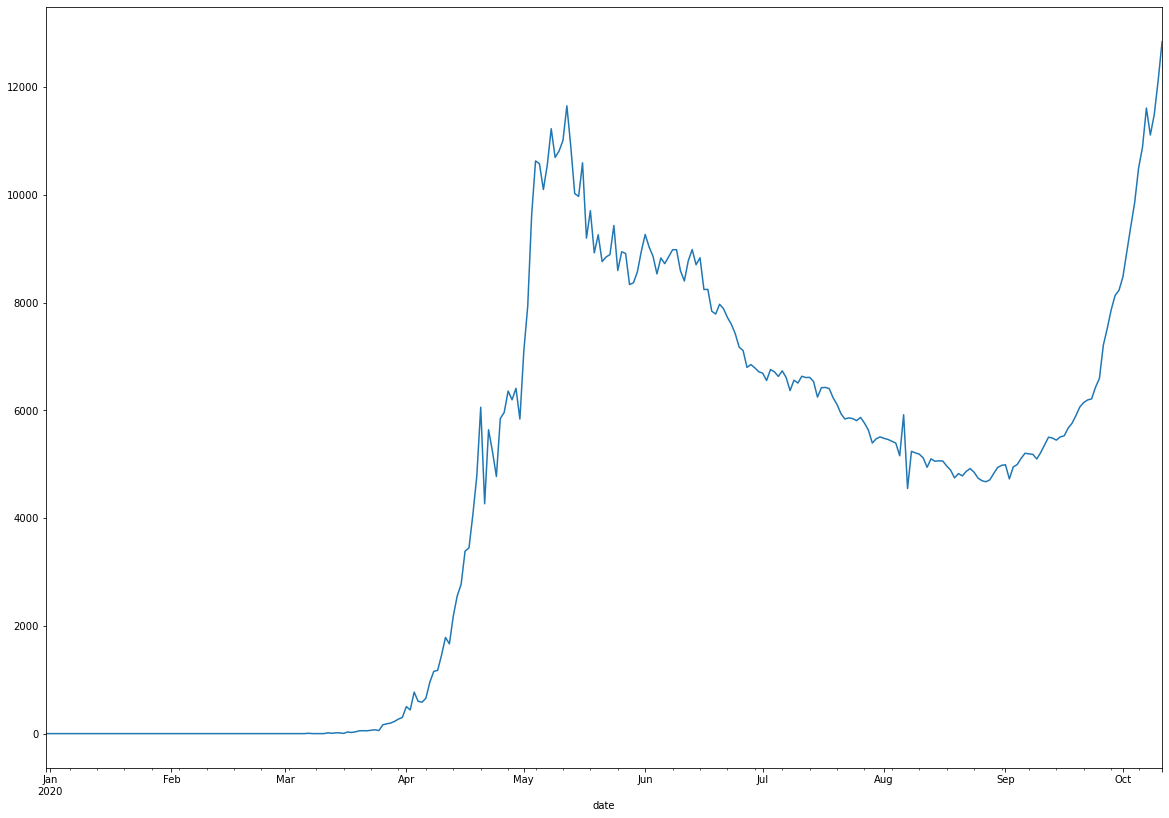

In [9]:
rus_covid.new_cases.plot()

Проверка станционарности с помощью критерия Дики-Фуллера: p=0.858539


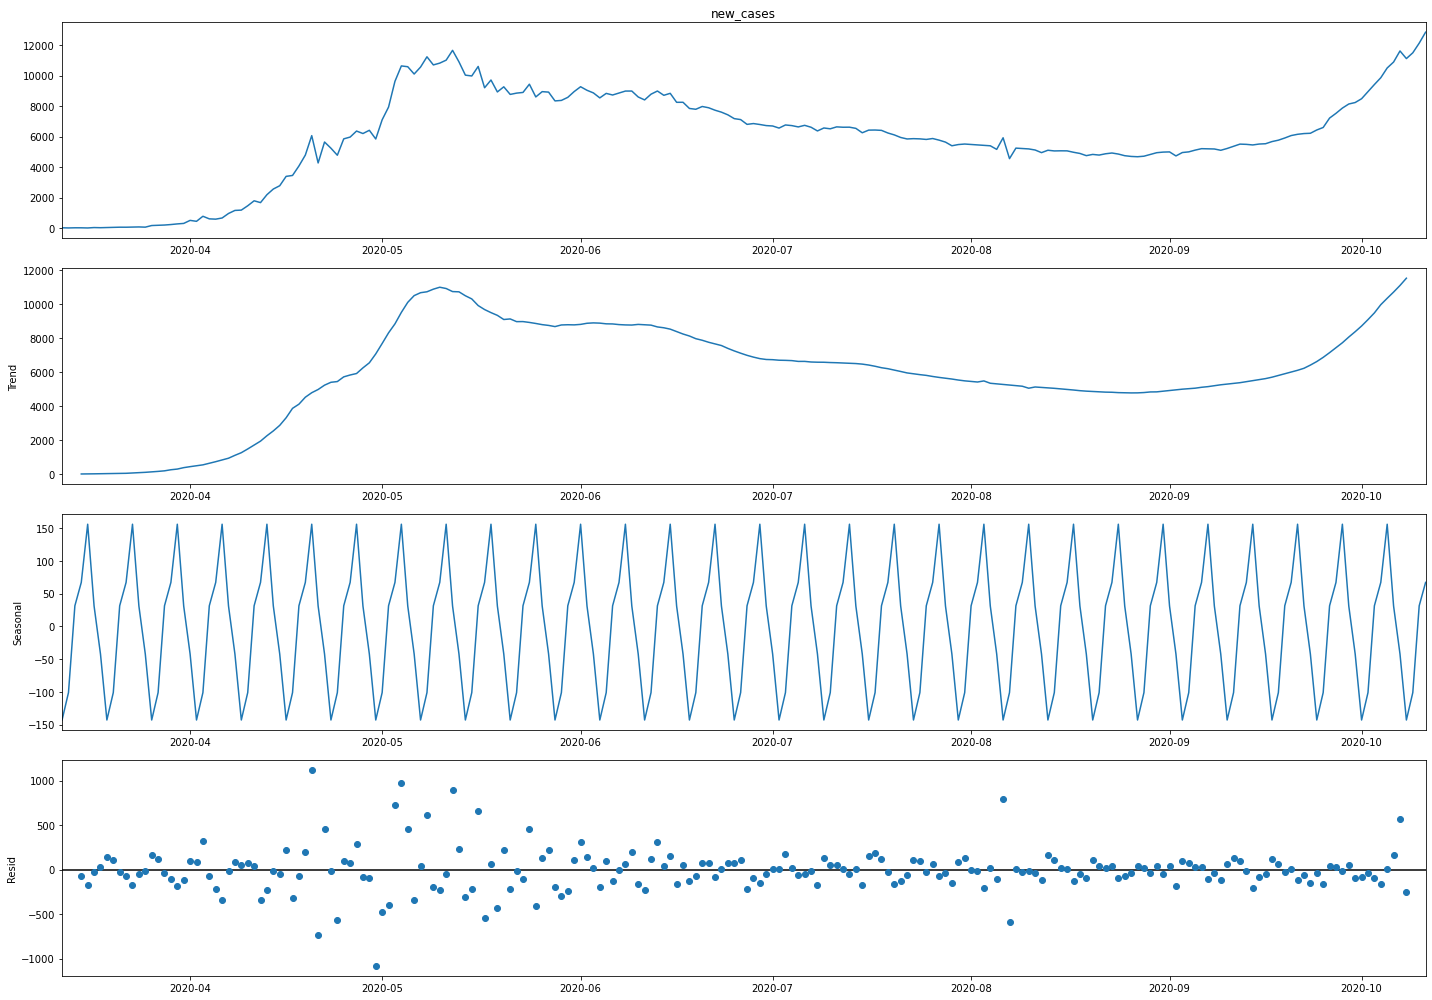

In [34]:
sm.tsa.seasonal_decompose(rus_covid.new_cases.iloc[72:]).plot()
print("Проверка станционарности с помощью критерия Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(rus_covid.new_cases)[1])

Период равен 7

/home/costia/anaconda3/envs/OBSPy/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Оптимальный параметр преобразования Бокса-Кокса: 0.851485
Критерий Дики-Фуллера: p=0.372473


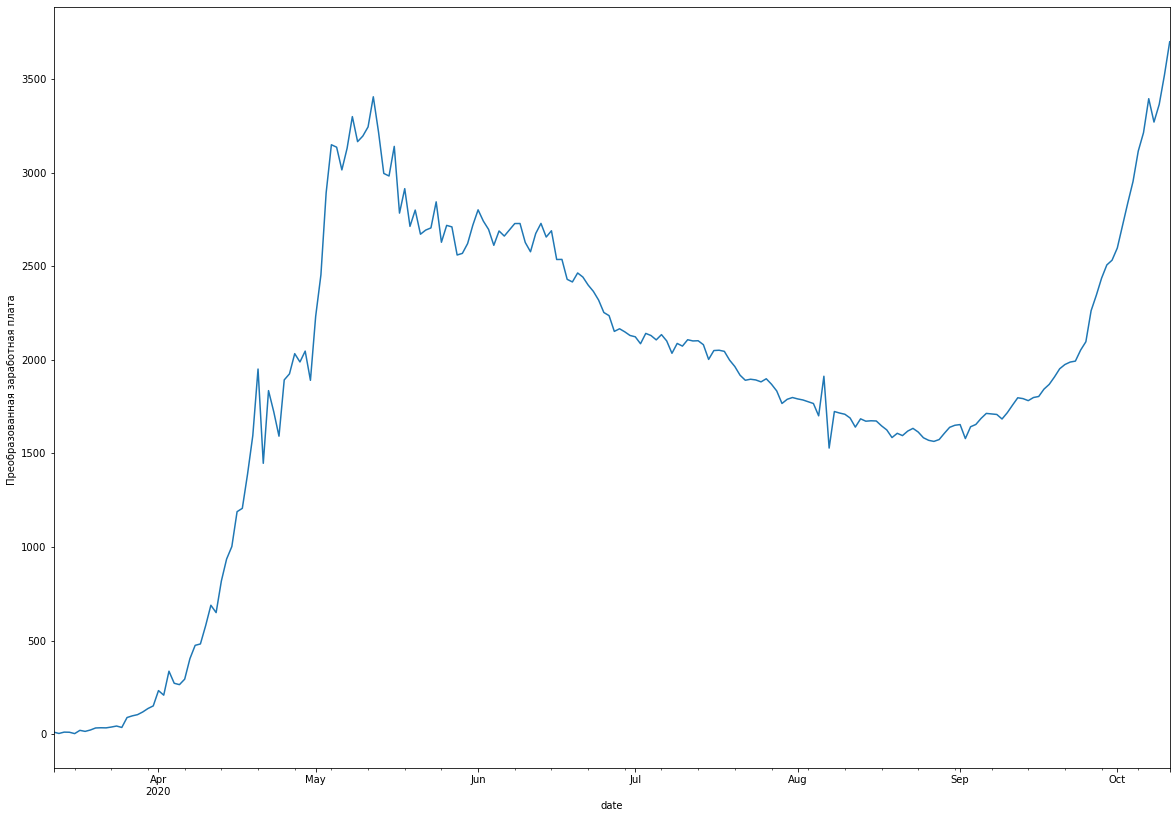

In [36]:
rus_covid['new_cases_boxcox'] = 0
rus_covid['new_cases_boxcox'].iloc[72:], lmbda = stats.boxcox(rus_covid.new_cases.iloc[72:])
plt.figure()
rus_covid.new_cases_boxcox.iloc[72:].plot()
plt.ylabel(u'Преобразованная заработная плата ')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(rus_covid.new_cases_boxcox.iloc[72:])[1])

In [38]:

#rus_covid['new_cases_boxcox'].iloc[72:]
rus_covid['daily_diff'] = 0
rus_covid['daily_diff'] = rus_covid['new_cases_boxcox'].iloc[72:] - rus_covid['new_cases_boxcox'].iloc[72:].shift(1)
print("Критерий Дики-Фуллера дифференцированный ряд: p=%f" % sm.tsa.stattools.adfuller(rus_covid.daily_diff.dropna())[1])

rus_covid['season_diff'] = 0
rus_covid['season_diff'] = rus_covid['new_cases_boxcox'].iloc[72:] - rus_covid['new_cases_boxcox'].iloc[72:].shift(7)
print("Критерий Дики-Фуллера сезонно дифференцированный ряд: p=%f" % sm.tsa.stattools.adfuller(rus_covid.season_diff.dropna())[1])
rus_covid['season_and_daily_diff'] = 0
rus_covid['season_and_daily_diff'] = rus_covid.daily_diff.iloc[72:] - rus_covid.daily_diff.iloc[72:].shift(7)
print("Критерий Дики-Фуллера дифференцированный и сезонно дифференцированный ряд: p={:.6}".format( sm.tsa.stattools.adfuller(rus_covid.season_and_daily_diff.dropna())[1]))

Критерий Дики-Фуллера дифференцированный ряд: p=0.061952
Критерий Дики-Фуллера сезонно дифференцированный ряд: p=0.709230
Критерий Дики-Фуллера дифференцированный и сезонно дифференцированный ряд: p=1.61954e-06


Критерий Дики-Фуллера: p=1.61954e-06


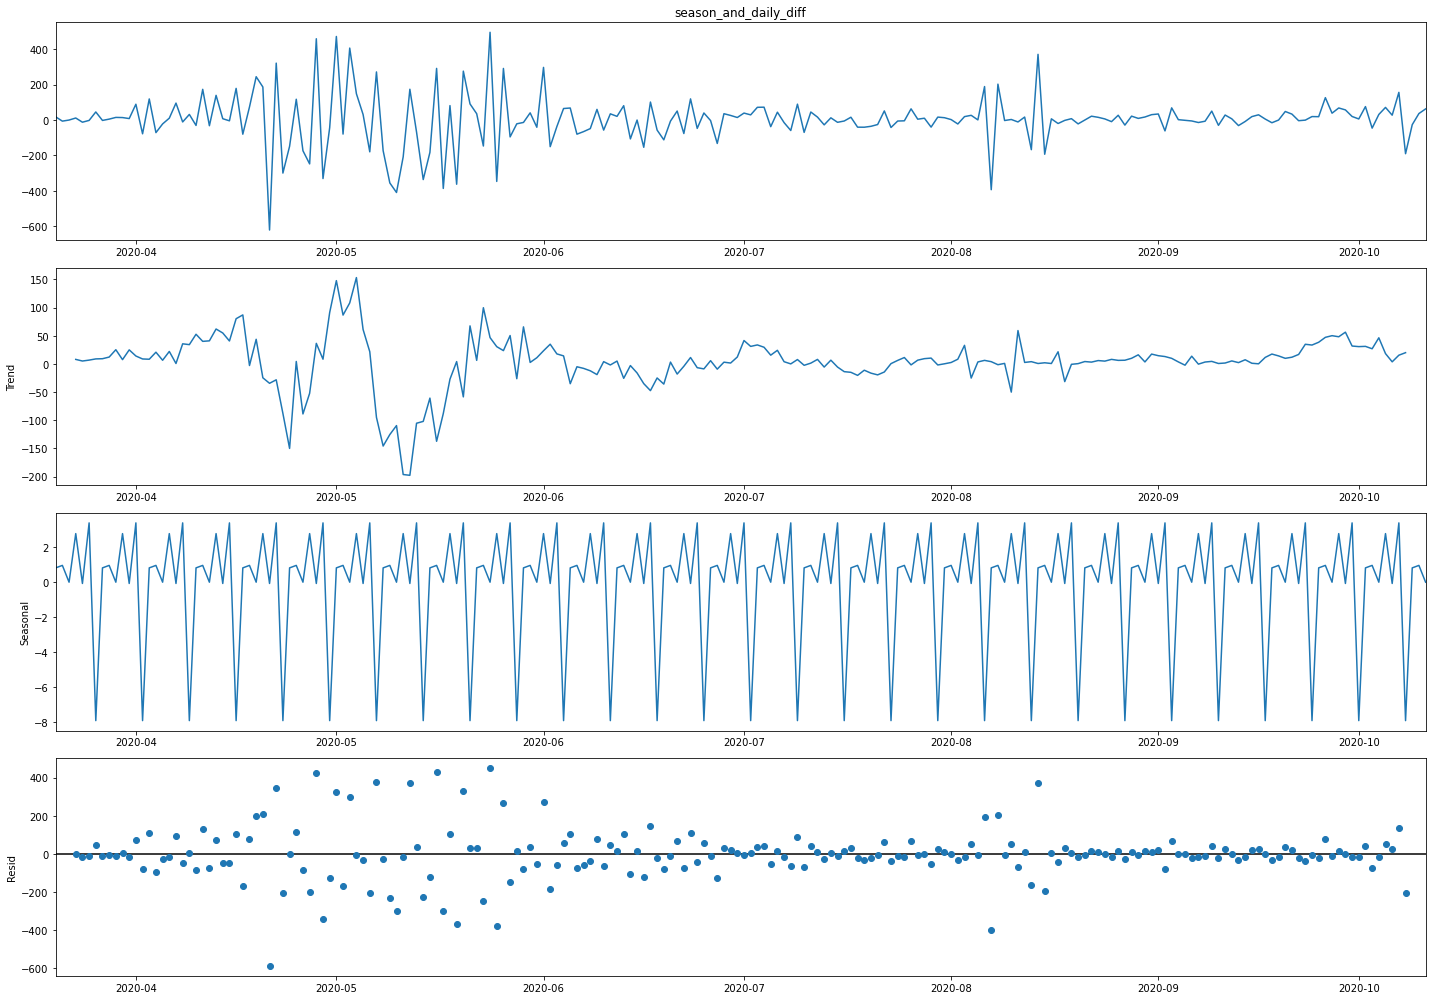

In [40]:
sm.tsa.seasonal_decompose(rus_covid.season_and_daily_diff.dropna()).plot()
print("Критерий Дики-Фуллера: p={:.6}".format(sm.tsa.stattools.adfuller(rus_covid.season_and_daily_diff.dropna())[1]))

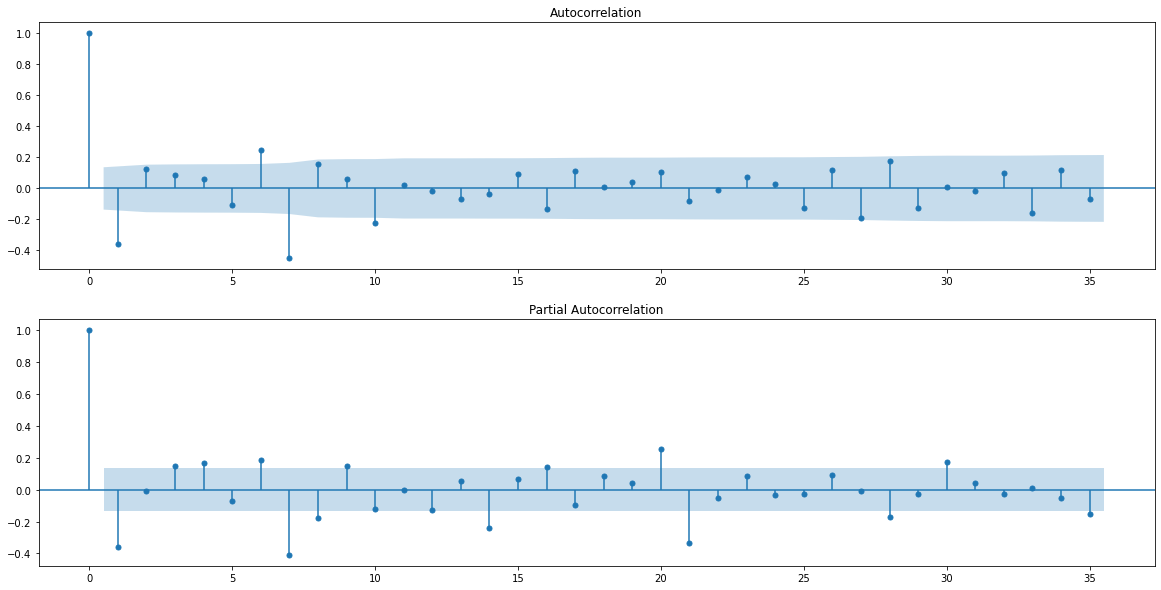

In [42]:
plt.figure(figsize = (20,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(rus_covid.season_and_daily_diff.dropna().values.squeeze(), lags=35, ax=ax);

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(rus_covid.season_and_daily_diff.dropna().values.squeeze(), lags=35,ax=ax);
plt.show()

Начальные приближения: Q=1, q=5, P=5, p=6
6 1 6 7

In [58]:
ps = range(0, 7)
d=1
qs = range(0, 3)
Ps = range(0, 6)
D=1
Qs = range(0, 2)

In [65]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print('Число наборов параметров:',len(parameters_list))

Число наборов параметров: 252


In [75]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(rus_covid.new_cases_boxcox.iloc[72:], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except (ValueError,np.linalg.LinAlgError) as e:  #LU decomposition error LinAlgError
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (5, 2, 4, 1)
wrong parameters: (6, 2, 4, 1)
CPU times: user 36min 38s, sys: 55 s, total: 37min 33s
Wall time: 11min 36s


In [50]:
# возможно надо обучать на ненулевых данных те .iloc[72:]

rus_covid.new_cases.isna().sum()

0

In [76]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters          aic
61   (1, 2, 0, 1)  2508.915640
85   (2, 1, 0, 1)  2509.542140
87   (2, 1, 1, 1)  2510.907324
97   (2, 2, 0, 1)  2511.388978
121  (3, 1, 0, 1)  2511.393623


/home/costia/anaconda3/envs/OBSPy/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                    new_cases_boxcox   No. Observations:                  214
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -1249.458
Date:                             Tue, 13 Oct 2020   AIC                           2508.916
Time:                                     08:24:34   BIC                           2525.555
Sample:                                 03-12-2020   HQIC                          2515.645
                                      - 10-11-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9386      0.041     23.153      0.000       0.859       1.018
ma.L1         -1.1648      

/home/costia/anaconda3/envs/OBSPy/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Стьюдента: p=0.755900
Критерий Дики-Фуллера: p=1.22219e-26


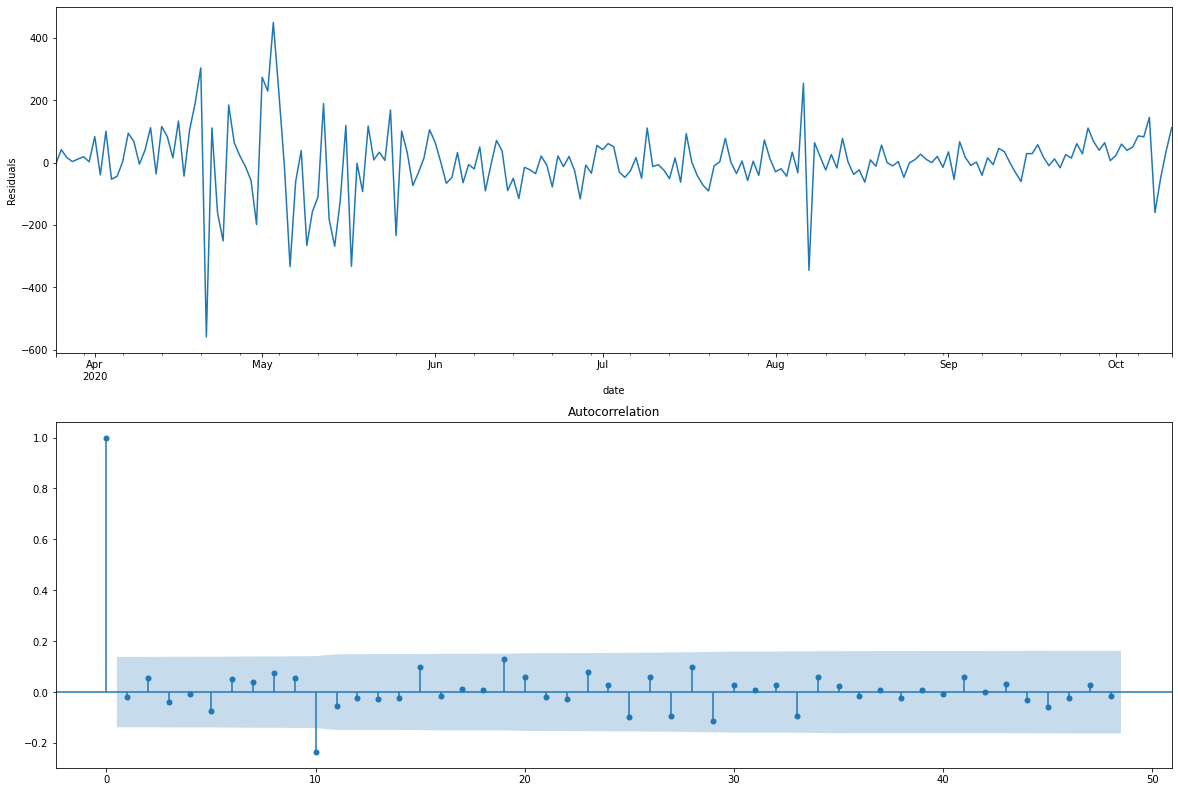

In [78]:
plt.figure()
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p={:.6}".format(sm.tsa.stattools.adfuller(best_model.resid[13:])[1]))

/home/costia/anaconda3/envs/OBSPy/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/costia/anaconda3/envs/OBSPy/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


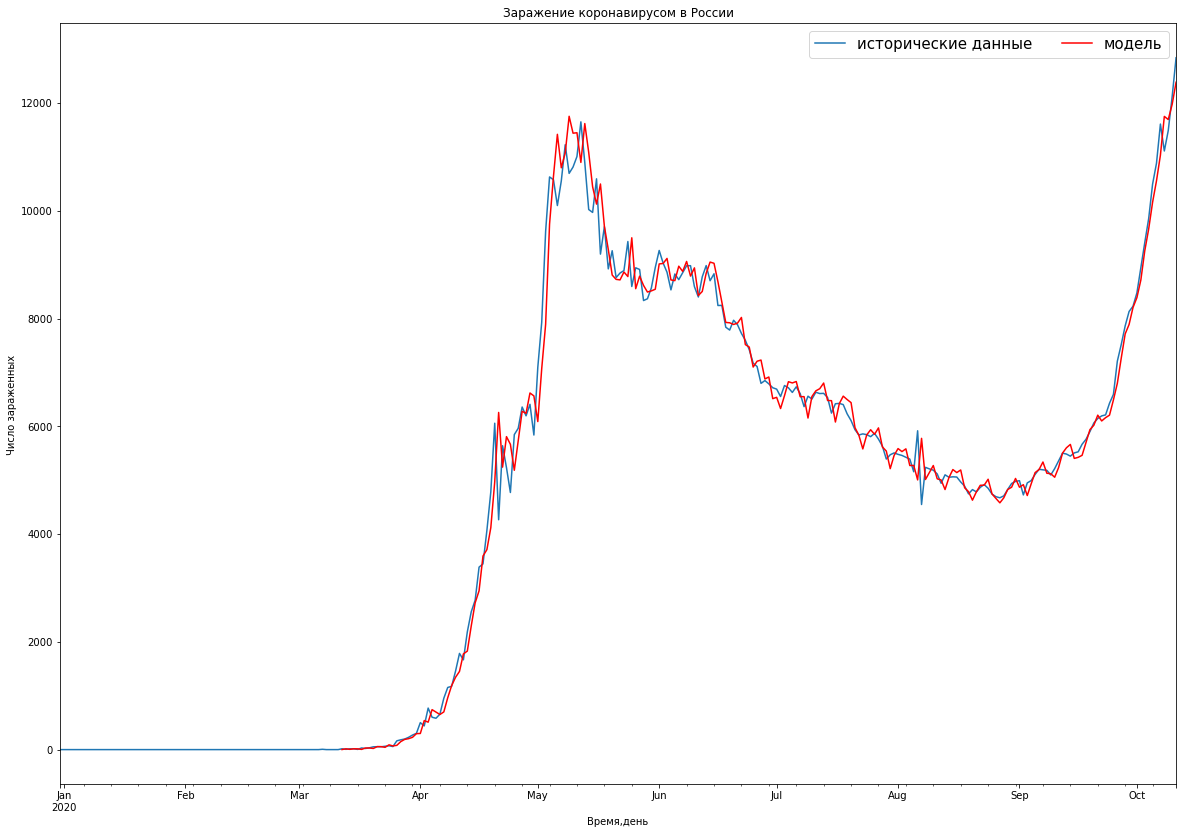

In [79]:
rus_covid['model'] = 0
rus_covid['model'].iloc[72:] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure()
rus_covid.new_cases.plot()
rus_covid.model[72:].plot(color='r')
plt.title('Заражение коронавирусом в России')
plt.xlabel('Время,день')
plt.ylabel('Число зараженных ')
plt.legend(['исторические данные','модель'], ncol=2, prop = {'size' : 15})
plt.show()

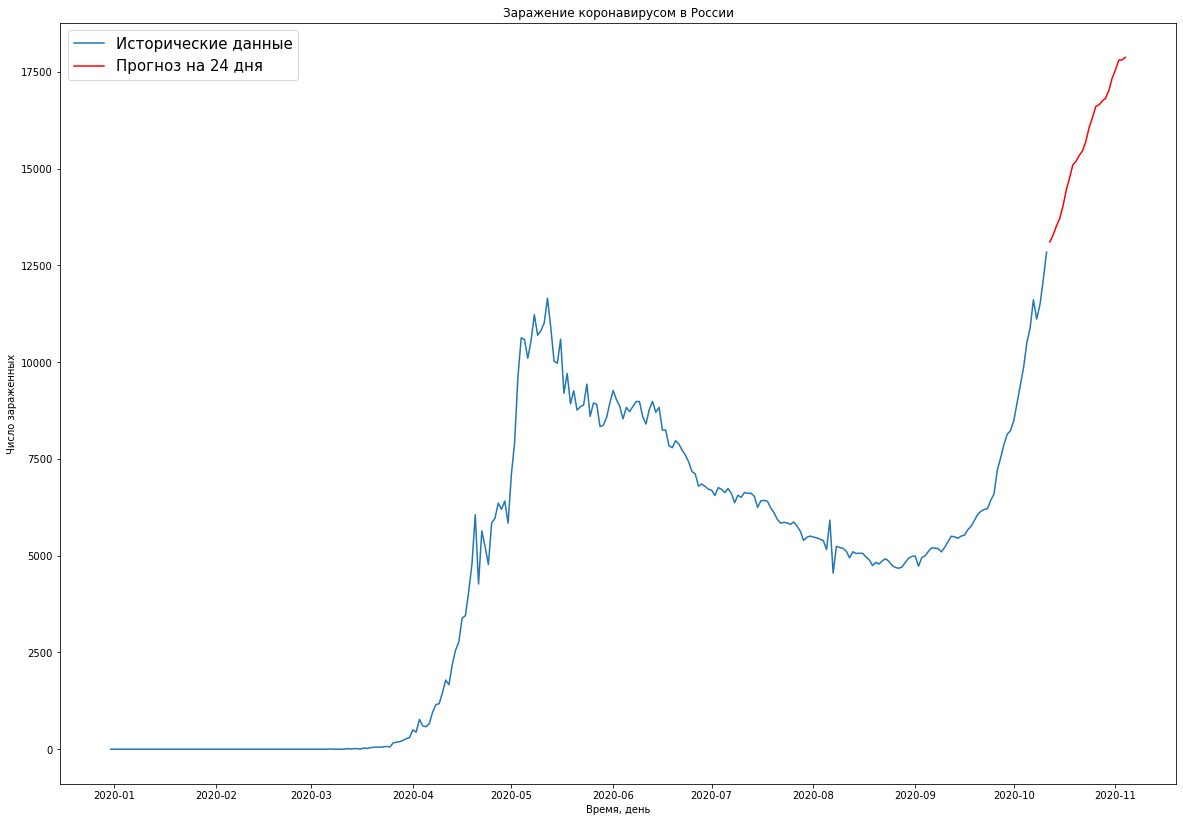

In [83]:
plt.figure()
plt.title('Заражение коронавирусом в России')
plt.xlabel('Время, день')
plt.ylabel('Число зараженных')
plt.plot(rus_covid.new_cases, label = 'Исторические данные')
plt.plot(invboxcox(best_model.forecast(24),lmbda), 'r', label = "Прогноз на 24 дня" )
plt.legend(prop = {'size' : 15})

In [81]:
invboxcox(best_model.forecast(24),lmbda)

2020-10-12    13107.961166
2020-10-13    13289.649926
2020-10-14    13519.246280
2020-10-15    13712.650060
2020-10-16    14028.982478
2020-10-17    14448.789454
2020-10-18    14758.796295
2020-10-19    15099.166164
2020-10-20    15197.005133
2020-10-21    15348.764961
2020-10-22    15468.374758
2020-10-23    15717.494186
2020-10-24    16075.734098
2020-10-25    16326.087155
2020-10-26    16610.793889
2020-10-27    16652.977676
2020-10-28    16753.211085
2020-10-29    16824.045113
2020-10-30    17028.939844
2020-10-31    17346.880085
2020-11-01    17558.170459
2020-11-02    17806.546777
2020-11-03    17812.182941
2020-11-04    17878.686259
Freq: D, dtype: float64